In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
import random
from tensorflow.keras.models import Model
import keras.backend as K

***Loading mnist dataset***

In [2]:
def load_dataset():
  (train_x, train_y), (_,_) = mnist.load_data()
  train_x = tf.cast(train_x, 'float32')/127.5-1
  train_x = tf.expand_dims(train_x, axis=-1)
  return train_x, train_y


# ***Selective data for supervised action***

In [3]:
def select_supervised_data(n_samples):
  n_class = 10
  x, y = load_dataset()

  image, label = [], []

  for i in range(10):
    randnum = np.random.randint(0, len(y), n_samples)
    Imgs = x[y==i]
    [image.append(x[num]) for num in randnum]
    [label.append(y[num]) for num in randnum]

  return np.array(image), np.array(label)


In [4]:
def generate_fake_samples(latentdim, n_samples):
  noise = tf.random.normal(shape=(n_samples, latentdim))

  return noise, tf.zeros(shape=(n_samples, ))

# ***Define the discriminator***

In [5]:
# custom activation function
def custom_activation(output):
 Z_x = K.sum(K.exp(output), axis=-1, keepdims=True)
 D_x = Z_x / (Z_x + 1.0)
 return D_x

# define  supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
 # image input
 in_image = layers.Input(shape=in_shape)
 # downsample
 fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
 fe = layers.LeakyReLU(alpha=0.2)(fe)
 # downsample
 fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
 fe = layers.LeakyReLU(alpha=0.2)(fe)
 # downsample
 fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
 fe = layers.LeakyReLU(alpha=0.2)(fe)
 # flatten feature maps
 fe = layers.Flatten()(fe)
 # dropout
 fe = layers.Dropout(0.4)(fe)
 # output layer nodes
 fe = layers.Dense(n_classes)(fe)
 # supervised output
 c_out_layer = layers.Activation('softmax')(fe)
 # define and compile supervised discriminator model
 c_model = Model(in_image, c_out_layer)
 c_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
 # unsupervised output
 d_out_layer = layers.Lambda(custom_activation)(fe)
 # define and compile unsupervised discriminator model
 d_model = Model(in_image, d_out_layer)
 d_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
 return d_model, c_model

# create model
disc_model, sup_model = define_discriminator()




In [6]:
sup_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

# ***Define Generator***

In [7]:
# define the standalone generator model
def define_generator(latent_dim):
 # image generator input
 in_lat = layers.Input(shape=(latent_dim,))
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 gen = layers.Dense(n_nodes)(in_lat)
 gen = layers.LeakyReLU(alpha=0.2)(gen)
 gen = layers.Reshape((7, 7, 128))(gen)
 # upsample to 14x14
 gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
 gen = layers.LeakyReLU(alpha=0.2)(gen)
 # upsample to 28x28
 gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
 gen = layers.LeakyReLU(alpha=0.2)(gen)
 # output
 out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
 # define model
 model = Model(in_lat, out_layer)
 return model

# ***Define GAN Model***

In [8]:
def define_gan(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect image output from generator as input to discriminator
 gan_output = d_model(g_model.output)
 # define gan model as taking noise and outputting a classification
 model = Model(g_model.input, gan_output)
 # compile model
 opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt)
 return model

In [9]:
c = define_generator(100)
c.output

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_3')>

# ***Monitor the perfomance of models***

In [10]:
def performance_monitoring(step, g_model, sup_model, dataset, latentdim, n_samples):

  x_sup, y_sup = dataset

  x_fake, _ = generate_fake_samples(latentdim, n_samples)

  fake_samples = g_model.predict(x_fake)
  fake_samples = fake_samples+1/2
  fake_samples = tf.cast(fake_samples, 'uint8')

  for i in range(n_samples):
    plt.subplot(10,10, i+1)
    plt.axis('off')
    plt.imshow(fake_samples[i,:,:,0])

  c_loss, c_acc = sup_model.evaluate(x_sup, y_sup)

  print('Classifier Accuracy: %.3f%%' % (c_acc * 100))

# ***Training Phase***

In [11]:
def train_models(g_model, gan_model, sup_model, disc_model, dataset, latentdim, n_samples=100):
  x_sup, y_sup = dataset

  epochs = 100

  for i in range(epochs):

    c_loss, c_acc = sup_model.train_on_batch(x_sup, y_sup)

    x_real, y_real = x_sup, tf.ones(shape = (n_samples*10, ))

    d1_loss = disc_model.train_on_batch(x_real, y_real)


    x_fake, y_fake =g_model.predict(tf.random.normal(shape =(n_samples,latentdim))), tf.zeros(shape = (n_samples, ))
    d2_loss = disc_model.train_on_batch(x_fake, y_fake)

    x_gan, y_gan = tf.random.normal(shape =(n_samples,latentdim)), np.ones((n_samples))

    gan_loss = gan_model.train_on_batch(x_gan, y_gan)

    print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d1_loss, d2_loss, gan_loss))

In [12]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = select_supervised_data(100)
# train model
train_models(g_model, gan_model, c_model, d_model, dataset, latent_dim)

4/4 [==============================] - 1s 250ms/step
>1, c[2.304,12], d[0.098,2.399], g[0.095]
4/4 [==============================] - 1s 264ms/step
>2, c[2.287,13], d[0.092,2.404], g[0.095]
4/4 [==============================] - 1s 149ms/step
>3, c[2.273,17], d[0.089,2.413], g[0.095]
4/4 [==============================] - 1s 251ms/step
>4, c[2.256,24], d[0.088,2.402], g[0.097]
4/4 [==============================] - 1s 145ms/step
>5, c[2.239,26], d[0.091,2.378], g[0.099]
4/4 [==============================] - 1s 147ms/step
>6, c[2.222,32], d[0.093,2.384], g[0.097]
4/4 [==============================] - 1s 150ms/step
>7, c[2.188,38], d[0.094,2.392], g[0.096]
4/4 [==============================] - 1s 253ms/step
>8, c[2.165,39], d[0.090,2.396], g[0.096]
4/4 [==============================] - 1s 155ms/step
>9, c[2.128,45], d[0.084,2.389], g[0.098]
4/4 [==============================] - 1s 152ms/step
>10, c[2.094,44], d[0.078,2.376], g[0.099]
4/4 [==============================] - 1s 150ms/s

In [16]:
x_fake = g_model.predict(tf.random.normal(shape =(100,100)))
x_fake = x_fake+1/2

4/4 [==============================] - 2s 327ms/step


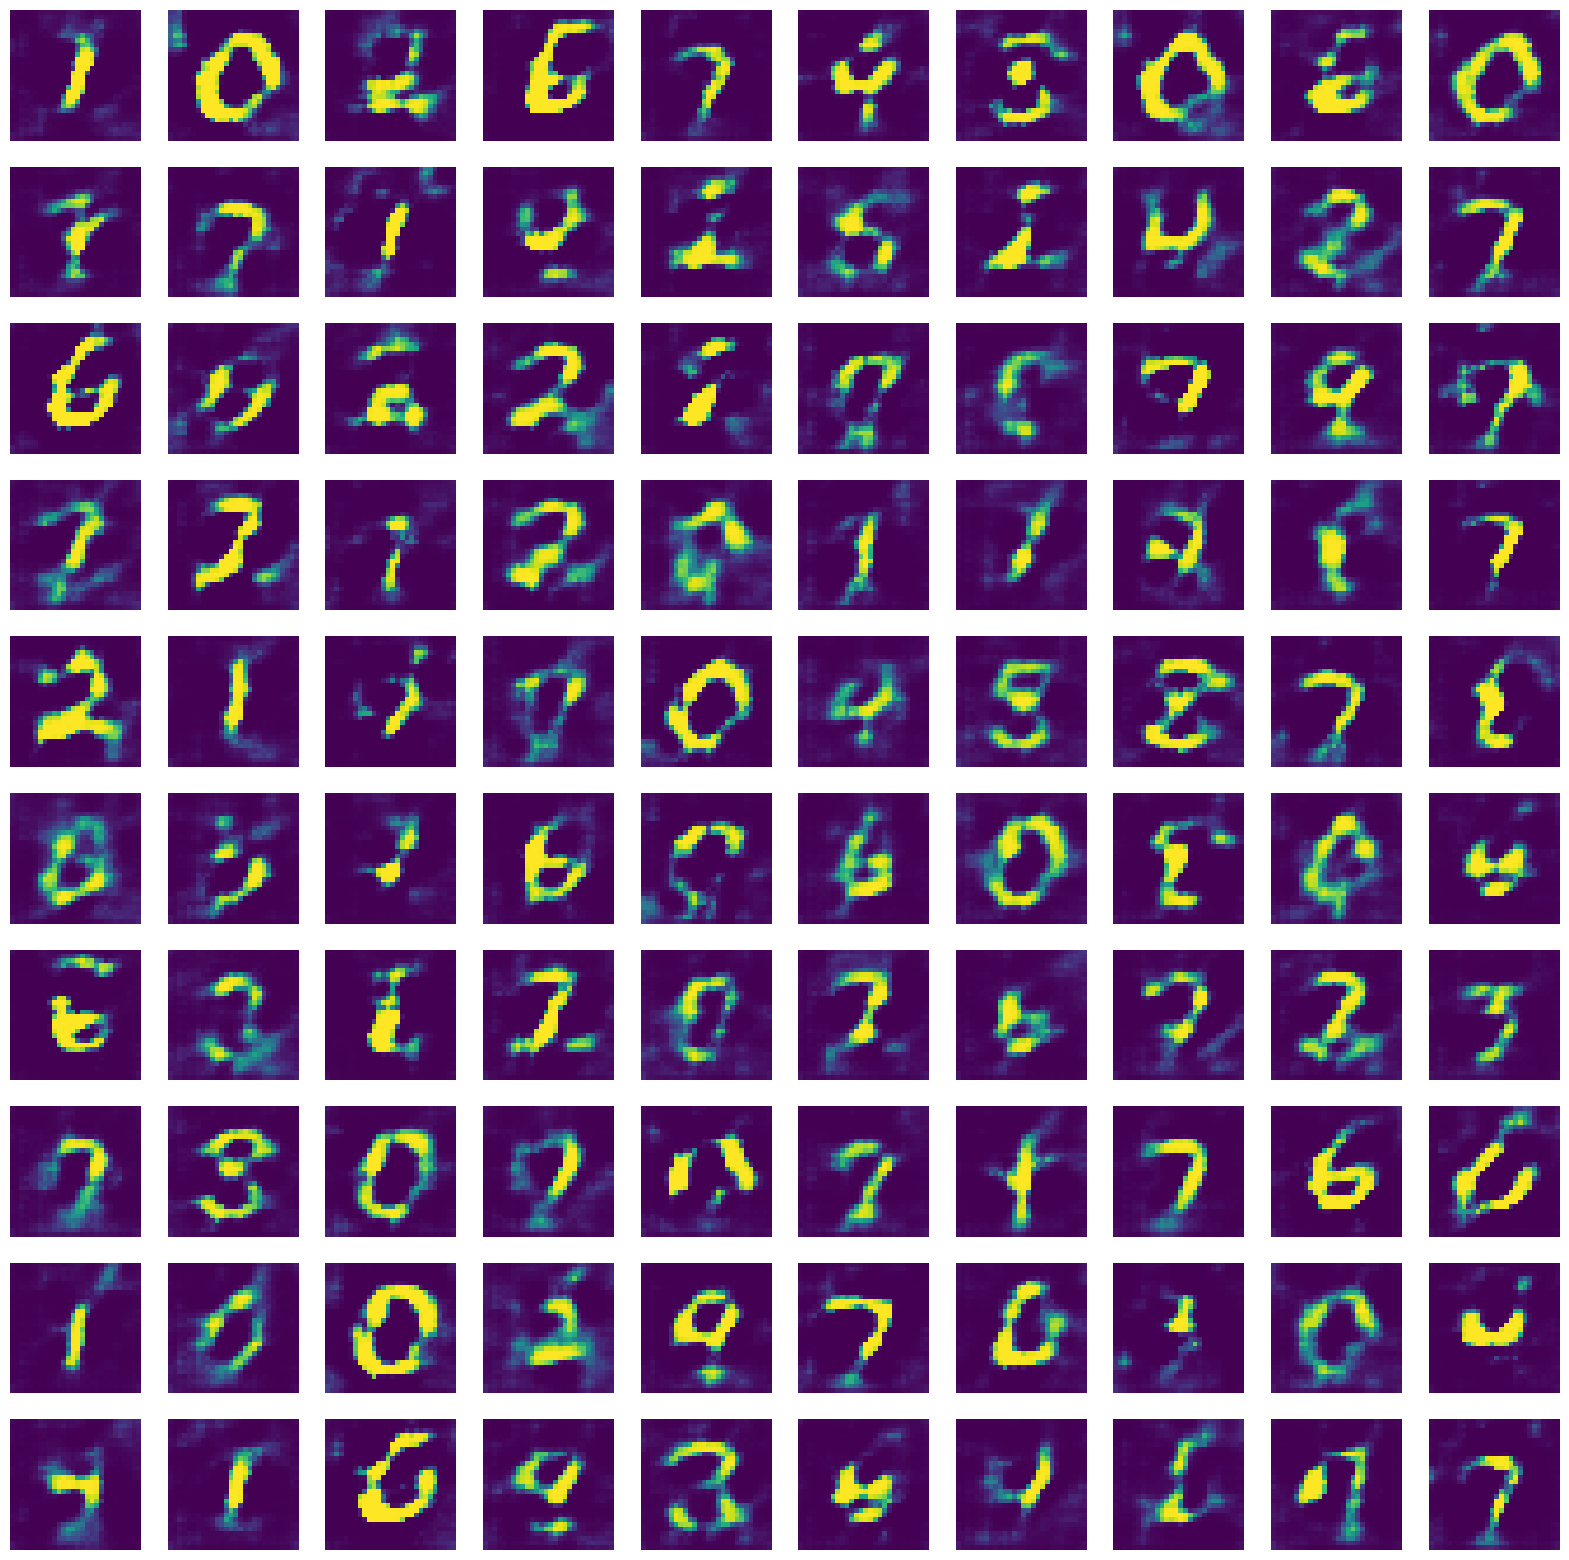

In [19]:
plt.figure(figsize=(20, 20))
for i in range(100):

  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(tf.squeeze(x_fake[i]))